(opcional) - Adiciona-se uma pasta pessoal presente no google drive na máquina, interessante para não ser necessário fazer o upload do datatet toda vez que reiniciar a máquina.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Instalando na máquina bibliotecas a serem utilizadas porém não previamente instaladas no colab 

In [ ]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng
! sudo apt install cm-super
! sudo pip install pyDOE
print("\nFinalizado!\n")


Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt

É importado as bilbiotecas a serem utilizadas, com o cuidado de selecionar a versão correta a ser utilizada pelo tensor flow.

In [ ]:
'''
from google.colab import drive
drive.mount('/content/gdrive/')
'''

#sys.path.insert(0, '/content/gdrive/My Drive/Colab Notebooks/pinn_burgers_equation_test')   #adiciona um "endereço" ao path, '0' é a posição

#%load plotting.py

%tensorflow_version 1.15.2
import tensorflow as tf 
print('TensorFlow version: ', tf.__version__)

import numpy as np 
import matplotlib.pyplot as plt 
import time  
import scipy.io  
#from plotting import newfig, savefig   
import matplotlib.gridspec as gridspec  
from mpl_toolkits.axes_grid1 import make_axes_locatable 

from scipy.interpolate import griddata  
from pyDOE import lhs   
from mpl_toolkits.mplot3d import Axes3D  

np.random.seed(1234)   
tf.set_random_seed(1234)   


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.2`. This will be interpreted as: `1.x`.


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow is already loaded. Please restart the runtime to change versions.
TensorFlow version:  1.15.2


Scrip de plotagem utilizado pelo autor Maziar Raissi, que será utilizado para criar os gráficos mais a frente. 

In [ ]:
#@title Default title text
#mraissi plotting script:

def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
#mpl.rcParams.update(pgf_with_latex)

# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))


In [ ]:
#Change plots dpi: 

plt.rcParams['figure.dpi'] = 200


Original: (não é necessário executar)

In [ ]:
'''
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, epochs, alpha):
        
        self.alpha = alpha

        self.lb = lb   
        self.ub = ub   
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.epochs = epochs
        self.layers = layers  
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf)  
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf) 
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,  
                                                                method = '                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ', 
                                                                options = {'maxiter': epochs, #50000  
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})  
        
        init = tf.global_variables_initializer()  
        self.sess.run(init)  
                
    def initialize_NN(self, layers):   
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):   
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):   
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):  
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u

    def net_f(self, x, t):   
        
        #burger's equation
        nu = 0.01/np.pi
        u = self.net_u(x,t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_xxx = tf.gradients(u_xx, x)[0]

        f = u_t + 6*u*u_x + u_xxx

        return f

    def callback(self, loss):   
        print('Loss:', loss)
        
    def train(self):   
        
        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)                                 
                                    
    def predict(self, X_star):   
                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return u_star, f_star
        '''


"\nclass PhysicsInformedNN:\n    # Initialize the class\n    def __init__(self, X_u, u, X_f, layers, lb, ub, epochs, alpha):\n        \n        self.alpha = alpha\n\n        self.lb = lb   \n        self.ub = ub   \n    \n        self.x_u = X_u[:,0:1]\n        self.t_u = X_u[:,1:2]\n        \n        self.x_f = X_f[:,0:1]\n        self.t_f = X_f[:,1:2]\n        \n        self.u = u\n        \n        self.epochs = epochs\n        self.layers = layers  \n        \n        # Initialize NNs\n        self.weights, self.biases = self.initialize_NN(layers)\n        \n        # tf placeholders and graph\n        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,\n                                                     log_device_placement=True))\n        \n        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])\n        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        \n        self.u_tf = tf.placeholder(tf.float32, s

É necessario adicionar um dataset que será utilizado como um grid pontos (coordenadas), para a rede neural. 
Deste dataset, é possivel:

1: atribuir uma solução exata a cada ponto do grid com o intuito de se comparar em seguida os resultados encontrados com o previtos. (com solução exata)

2: atribuir uma solução somente aos pontos de iniciais e de contorno (sem solução exata), neste caso, por facilidade as condições iniciais são aplicadas em todo o dataset.


Em ambos os casos, para gerar a solução prevista, somente serão utilizados os dados das condições iniciais e de contorno. 

Editar Dataset: (com solução exata)

Importante!
Foi utilizado o dataset utilizado na equação de burgers como base, tal arquivo precisa ser importado pela máquina.

https://github.com/maziarraissi/PINNs/blob/master/appendix/Data/burgers_shock.mat

Full dictionary overview:

 {'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Sep 20 16:38:22 2017', '__version__': '1.0', '__globals__': [], 'x': array([[-1.        ],
       [-0.99215686],
       [-0.98431373],
       [-0.97647059],
       [-0.96862745],
       [-0.96078431],
       [-0.95294118],
       [-0.94509804],
       [-0.9372549 ],
       [-0.92941176],
       [-0.92156863],
       [-0.91372549],
       [-0.90588235],
       [-0.89803922],
       [-0.89019608],
       [-0.88235294],
       [-0.8745098 ],
       [-0.86666667],
       [-0.85882353],
       [-0.85098039],
       [-0.84313725],
       [-0.83529412],
       [-0.82745098],
       [-0.81960784],
       [-0.81176471],
       [-0.80392157],
       [-0.79607843],
       [-0.78823529],
       [-0.78039216],
       [-0.77254902],
       [-0.76470588],
       [-0.75686275],
       [-0.74901961],
       [-0.74117647],
       [-0.73333333],
       [-0.7254902 ],
       [-0.71764706],
       [-0.70980392

/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


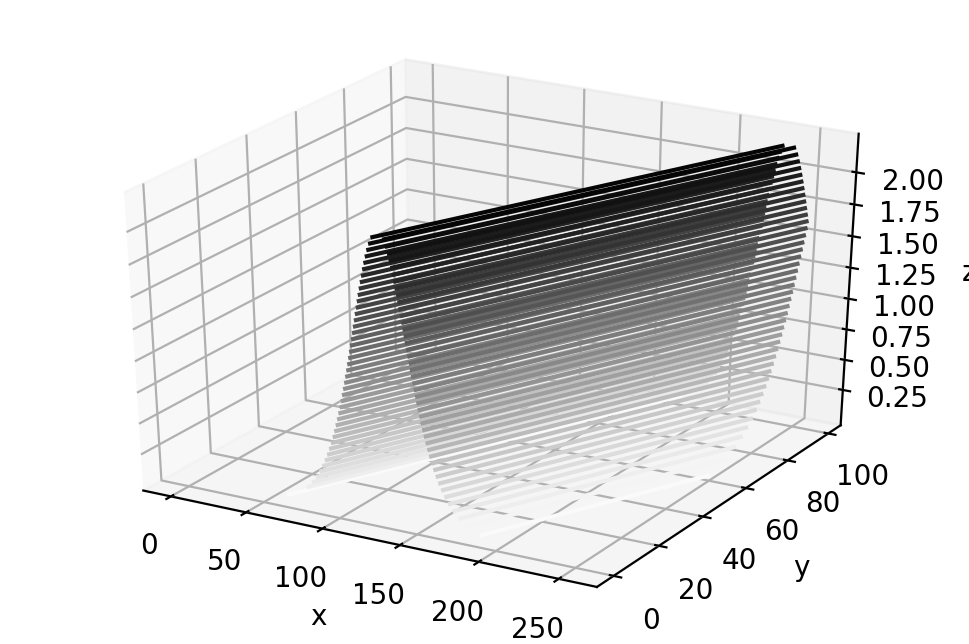

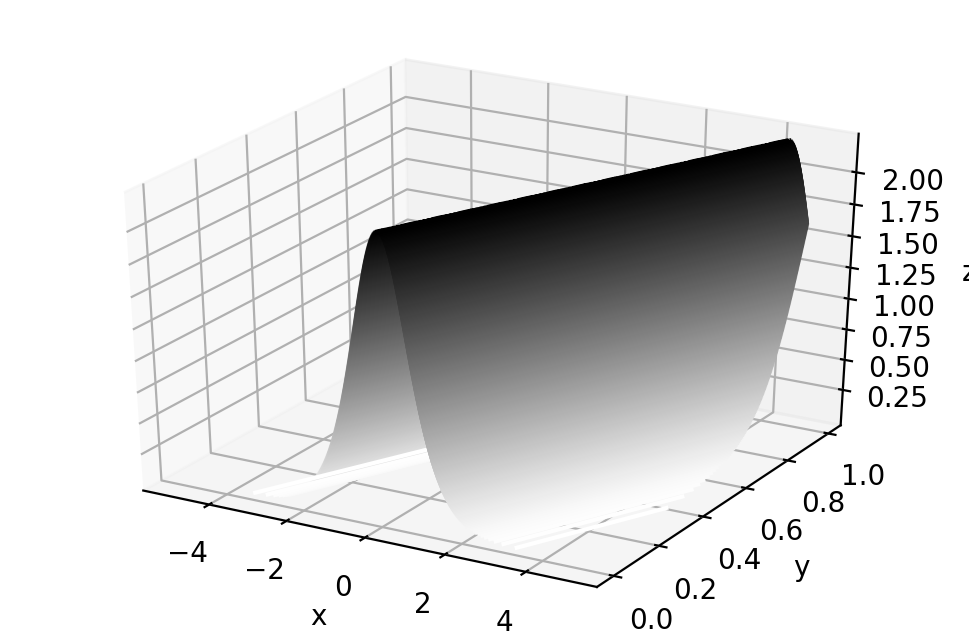

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:104: UserWarning: The following kwargs were not used by contour: 'rstride', 'edgecolor'


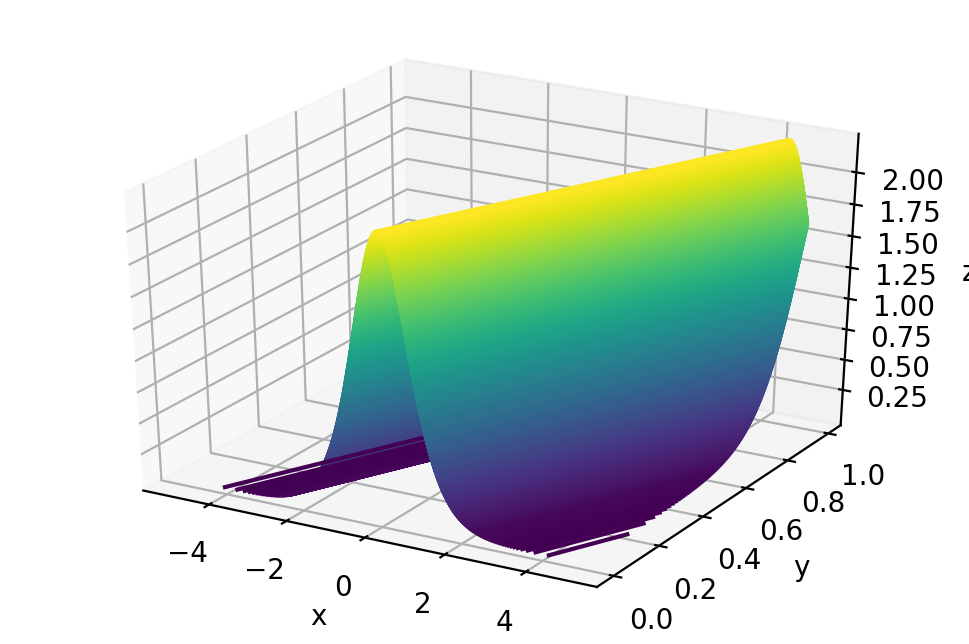

In [ ]:
#IMPORTAR ALGUM DATASET:

#Import scipy function that works with Matlab files (.mat):
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import numpy as np

#Choose a base file to load and attribute a name. This will return a Python dictionary:
#Old:   'burgers_shock.mat'
full_data = loadmat('/content/drive/MyDrive/data/burgers_shock.mat') #inserir caminho para o dataset aqui!
full_data_test = []
full_data_test = full_data
print('Full dictionary overview:\n\n', full_data, '\n')

#Here we can see the keys of the .mat file (now a Python dictionary):
print('Dictionary Keys:\n\n', full_data.keys(), '\n')

#More data about our file:

#Discretized coordinates (points) of the spatio-temporal dimensions:
print('x points from the data:\n\n', full_data['x'].shape,'\n\n', full_data['x'], '\n')
print('t points from the data:\n\n', full_data['t'].shape,'\n\n', full_data['t'], '\n')

#pontos gerados pela solução exata
print('usol points from the data:\n\n', full_data['usol'].shape, '\n\n', full_data['usol'], '\n')

#ALTERAR SOLUÇÂO:



#modificar o domínio de x para -5<=x<=5
#inicialmente o valor definido era de -1 <=x<= 1, tal valor foi dilatado multiplicando cada ponto do dataset por 5:
for i in range(full_data['x'].shape[0]):
    full_data['x'][i]*=5

#modificar o domínio de t (caso necessário basta dilatar ou transladar o domínio temporal)
for i in range(full_data['t'].shape[0]):
    full_data['t'][i]*=1

#change solution completely:
beta=4.5 
for i in range(full_data['x'].shape[0]):
    for j in range(full_data['t'].shape[0]):

          
        full_data['usol'][i,j] = beta*0.5*(1/np.cosh(np.sqrt(beta)*0.5*(full_data['x'][i]-beta*full_data['t'][j])))**2 #solução no caso de 1 sóliton.
        
        #full_data['usol'][i,j] = 12*(( 3+4*np.cosh(2*full_data['x'][i] - 8*full_data['t'][j]) + np.cosh( 4*full_data['x'][i] \ 
        #- 64*full_data['t'][j]))/(3*np.cosh(full_data['x'][i] - 28*full_data['t'][j])+np.cosh(3*full_data['x'][i]-36*full_data['t'][j]))**2) #solução caso dois sólitons

#PRINT:


def f(x, y):
    return full_data['usol'][x, y]

#index values:

tmp_x = []
for i in range(full_data['x'].shape[0]): 
    tmp_x.append(i)

tmp_t = []
for i in range(full_data['t'].shape[0]): 
    tmp_t.append(i)

X, Y = np.meshgrid(np.array(tmp_x), np.array(tmp_t))
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

#real values:

tmp_x = []
for i in range(full_data['x'].shape[0]): 
    tmp_x.append(full_data['x'][i][0])

tmp_t = []
for i in range(full_data['t'].shape[0]): 
    tmp_t.append(full_data['t'][i][0])

X, Y = np.meshgrid(np.array(tmp_x), np.array(tmp_t))
#Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 300, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 1500, rstride=1, 
                cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

#SALVAR DATASET TEMPORARIAMENTE NA MÁQUINA:

savemat('dataset_tmp.mat', full_data)


Editar dataset: (sem solução exata)

In [ ]:
'''
#@title
#IMPORTAR ALGUM DATASET:

#Import scipy function that works with Matlab files (.mat):
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import numpy as np

#Choose a base file to load and attribute a name. This will return a Python dictionary:
#full_data = loadmat('/content/drive/MyDrive/Colab Notebooks/alan_PIBIC/PINN_datagenerator/burgers_shock.mat')   #Old:   'burgers_shock.mat'
full_data = loadmat('/content/drive/MyDrive/data/burgers_shock.mat')
full_data_test = []
full_data_test = full_data
print('Full dictionary overview:\n\n', full_data, '\n')

#Here we can see the keys of the .mat file (now a Python dictionary):
print('Dictionary Keys:\n\n', full_data.keys(), '\n')

#More data about our file:

#Discretized coordinates (points) of the spatio-temporal dimensions:
#print('x points from the data:\n\n', full_data['x'].shape,'\n\n', full_data['x'], '\n')
#print('t points from the data:\n\n', full_data['t'].shape,'\n\n', full_data['t'], '\n')

#pontos gerados pela solução exata
#print('usol points from the data:\n\n', full_data['usol'].shape, '\n\n', full_data['usol'], '\n')

#ALTERAR SOLUÇÂO:

beta=7

for i in range(full_data['x'].shape[0]):
    full_data['x'][i]=full_data['x'][i]+1

for i in range(full_data['t'].shape[0]):
    full_data['t'][i]*=1
#change solution completely:
for i in range(full_data['x'].shape[0]):
    for j in range(full_data['t'].shape[0]):
        #Heat equation:
        #full_data['usol'][i,j] = np.exp(-(full_data['x'][i]-3)**2)+2*np.exp(-(full_data['x'][i]+3)**2)+3*np.exp(-(full_data['x'][i])**2)
        #full_data['usol'][i,j] = np.exp(-1*(full_data['x'][i])**2)
        full_data['usol'][i,j] = np.cos(np.pi* full_data['x'][i])
        #full_data['usol'][i,j] = 2*np.sin(full_data['x'][i])
        #ull_data['usol'][i,j] = 6*(1/np.cosh(full_data['x'][i]))**2

#PRINT:

def f(x, y):
    return full_data['usol'][x, y]

#index values:

tmp_x = []
for i in range(full_data['x'].shape[0]): 
    tmp_x.append(i)

tmp_t = []
for i in range(full_data['t'].shape[0]): 
    tmp_t.append(i)

X, Y = np.meshgrid(np.array(tmp_x), np.array(tmp_t))
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

#real values:

tmp_x = []
for i in range(full_data['x'].shape[0]): 
    tmp_x.append(full_data['x'][i][0])

tmp_t = []
for i in range(full_data['t'].shape[0]): 
    tmp_t.append(full_data['t'][i][0])

X, Y = np.meshgrid(np.array(tmp_x), np.array(tmp_t))
#Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 300, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 1500, rstride=1, 
                cmap='viridis', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

#SALVAR DATASET TEMPORARIAMENTE NA MÁQUINA:

savemat('dataset_tmp.mat', full_data)
'''


"\n#@title\n#IMPORTAR ALGUM DATASET:\n\n#Import scipy function that works with Matlab files (.mat):\nfrom scipy.io import loadmat, savemat\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n#Choose a base file to load and attribute a name. This will return a Python dictionary:\n#full_data = loadmat('/content/drive/MyDrive/Colab Notebooks/alan_PIBIC/PINN_datagenerator/burgers_shock.mat')   #Old:   'burgers_shock.mat'\nfull_data = loadmat('/content/drive/MyDrive/data/burgers_shock.mat')\nfull_data_test = []\nfull_data_test = full_data\nprint('Full dictionary overview:\n\n', full_data, '\n')\n\n#Here we can see the keys of the .mat file (now a Python dictionary):\nprint('Dictionary Keys:\n\n', full_data.keys(), '\n')\n\n#More data about our file:\n\n#Discretized coordinates (points) of the spatio-temporal dimensions:\n#print('x points from the data:\n\n', full_data['x'].shape,'\n\n', full_data['x'], '\n')\n#print('t points from the data:\n\n', full_data['t'].shape,'\n\n', full_data['

Schrodinger-based, baseado no script relacionado a solução da equação de Schrodinger, (básicamente foi apagado a parte imaginaria, no script,  apesar de que se faz necessário cuidado ao modificar os termos.)

In [ ]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, tb, X_f, layers, lb, ub):
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        #X0 = np.concatenate((x0, 0.5*np.ones((100, 1))), 1)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
        #self.v0 = v0
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        #self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        # tf Graphs
        self.u0_pred, _ = self.net_u(self.x0_tf, self.t0_tf)
        self.u_lb_pred, self.u_x_lb_pred = self.net_u(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, self.u_x_ub_pred = self.net_u(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred = self.net_f_u(self.x_f_tf, self.t_f_tf)
        
        # Loss
 
        #sem condição de contorno
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred))                             

       
       
        '''
        # Loss

        #custom
         self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    10**(-3)*tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) 

       #com condição de contorno
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred))

        #original
        self.loss = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.u_x_lb_pred - self.u_x_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred))
        '''

        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 3000, #50000
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol': 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_u(self, x, t):
        X = tf.concat([x,t],1)
        
        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:,0:1]
        #v = uv[:,1:2]
        
        u_x = tf.gradients(u, x)[0]
        #v_x = tf.gradients(v, x)[0]

        return u, u_x

    def net_f_u(self, x, t):

        u, u_x = self.net_u(x,t) #u, u_x = self.net_u(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_xxx = tf.gradients(u_xx, x)[0]
        #f_u = u_t + u*u_x + 0.022**2*u_xxx
        f_u = u_t + 6*u*u_x + u_xxx
        
        return f_u
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        #v_star = self.sess.run(self.v0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        #f_v_star = self.sess.run(self.f_v_pred, tf_dict)
               
        return u_star, f_u_star


if __name__ == "__main__": 
                # [x, t]
    lb = np.array([-5, 0])
    ub = np.array([5, 1])   #Definir as condições na mão mesmo, ou fazer um script para automatizar

    N0 = 100 #50
    N_b = 0
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1]   #Alterar a rede para ficar igual a anterior
        
    data = scipy.io.loadmat('/content/dataset_tmp.mat')   #importar dataset temporário
    
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]   #tensor dos dados do label 'x' da library
    Exact = data['usol']   #tensor dos dados do label 'uu'
    Exact_u = np.real(Exact)   #tensor com a parte real da solução
    #Exact_v = np.imag(Exact)   #tensor com a parte imaginária
    ##Exact_h = np.sqrt(Exact_u**2)   #tensor módulo da parte real e imaginária
    Exact_h = Exact_u
    X, T = np.meshgrid(x,t)   #cria um tensor com a lista x e t
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))   #salva o tensor anterior em novo nome
    u_star = Exact_u.T.flatten()[:,None]   #salva novamente a parte real da solução
    #v_star = Exact_v.T.flatten()[:,None]   #salva novamente a parte imaginária da solução
    h_star = Exact_h.T.flatten()[:,None]   #salva novamente o módulo de u e v
    
    ###########################
    
    idx_x = np.random.choice(x.shape[0], N0, replace=False)   #sorteia alguns pontos em x para criar uma sample
    x0 = x[idx_x,:]   #pega dados referentes aos índices antereiores
    u0 = Exact_u[idx_x,0:1]   #pega dados referentes aos índices antereiores
    #u0 = Exact_u[idx_x,50:51] #caso em que a condição inicial ocorre no ponto 50.
    #v0 = Exact_v[idx_x,0:1]   #pega dados referentes aos índices antereiores
    
    idx_t = np.random.choice(t.shape[0], N_b, replace=False)   #seleciona alguns pontos em t para gerar a outra parte do sample
    tb = t[idx_t,:]   #pega dados referentes aos índices anteriores
    
    X_f = lb + (ub-lb)*lhs(2, N_f)

          #def __init__(self, x0, u0, tb, X_f, layers, lb, ub):     
    model = PhysicsInformedNN(x0, u0, tb, X_f, layers, lb, ub)   #chama a função PINN criando o modelo
  
    start_time = time.time()   #começa a contar o tempo de treino
    
    model.train(5000)  #50000 #treina o modelo em 'n épocas'

    elapsed = time.time() - start_time   #calcula o tempo decorrido
    print('Training time: %.4f' % (elapsed))   #printa o tempo decorrido
    
    u_pred, f_u_pred = model.predict(X_star)   #prevê soluções para X_star
    #h_pred = np.sqrt(u_pred**2)   #gera o módulo das previsões u e v
    h_pred = u_pred


    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)   #calcula o erro da parte real
    #error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)   #calcula o erro da parte imaginária
    error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)   #calcula o erro do módulo
    print('Error u: %e' % (error_u))   #printa o erro...
    #print('Error v: %e' % (error_v))   #printa o erro...
    print('Error h: %e' % (error_h))   #printa o erro...


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

It: 0, Loss: 6.394e-01, Time: 6.61
It: 10, Loss: 5.269e-01, Time: 0.34
It: 20, Loss: 4.610e-01, Time: 0.31
It: 30, Loss: 4.617e-01, Time: 0.32
It: 40, Loss: 4.510e-01, Time: 0.29
It: 50, Loss: 4.417e-01, Time: 0.29
It: 60, Loss: 3.987e-01, Time: 0.30
It: 70, Loss: 3.001e-01, Time: 0.29
It: 80, Loss: 2.057e-01, Time: 0.30
It: 90, Loss: 1.348e-01, Time: 0.29
It: 100, Loss: 8.514e-02, Time: 0.29
It: 110, Loss: 6.406e-02, Time: 0.29
It: 120, Loss: 4.006e-02, Time: 0.29
It: 130, Loss: 3.154e-02, Time: 0.31
It: 140, Loss: 2.433e-02, Time: 0.29
It: 150, Loss: 1.927e-02, Time: 0.30
It: 160, Loss: 1.611e-02, Time: 0.30
It: 170, Loss: 2.332e-02, Time: 0.29
It: 180, Loss: 1.319e-02, Time: 0.30
It: 190, Loss: 7

Gráfico da solução exata:

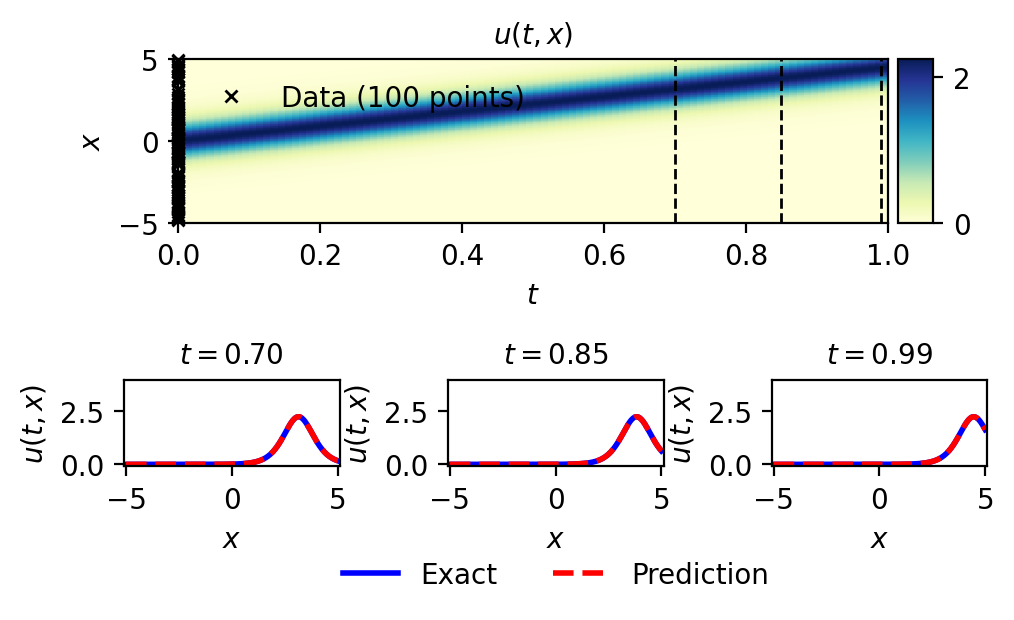

In [ ]:
if __name__ == "__main__": 

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    U_exact= griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    #V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')   #interpola os dados...

    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    #FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    

    ############################# Plotting ###############################
   
    
    X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
    #X0 = np.concatenate((x0, 0.5*np.ones((100, 1))), 1)
    X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
    X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
    X_u_train = np.vstack([X0, X_lb, X_ub])

    fig, ax = newfig(1.0, 0.9)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
    
    # dos 3 cortes temporais, fiz esta implementação simplória de ser potado o corte no tempo relativo ao dado a,b e c. (ao invés de modificar em todas as linhas)
    
    a=70
    b=a+15
    c=b+14

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[a]*np.ones((2,1)), line, 'k--', linewidth = 1)
    ax.plot(t[b]*np.ones((2,1)), line, 'k--', linewidth = 1)
    ax.plot(t[c]*np.ones((2,1)), line, 'k--', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    leg = ax.legend(frameon=False, loc = 'best')
    #plt.setp(leg.get_texts(), color='w')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: h(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact_h[:,a], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[a,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[a]), fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,4])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact_h[:,b], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[b,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,4])
    ax.set_title('$t = %.2f$' % (t[b]), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact_h[:,c], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[c,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,4])    
    ax.set_title('$t = %.2f$' % (t[c]), fontsize = 10)
    
    # savefig('./figures/NLS') 


Gráfico sem solução exata: (não possui comparação)

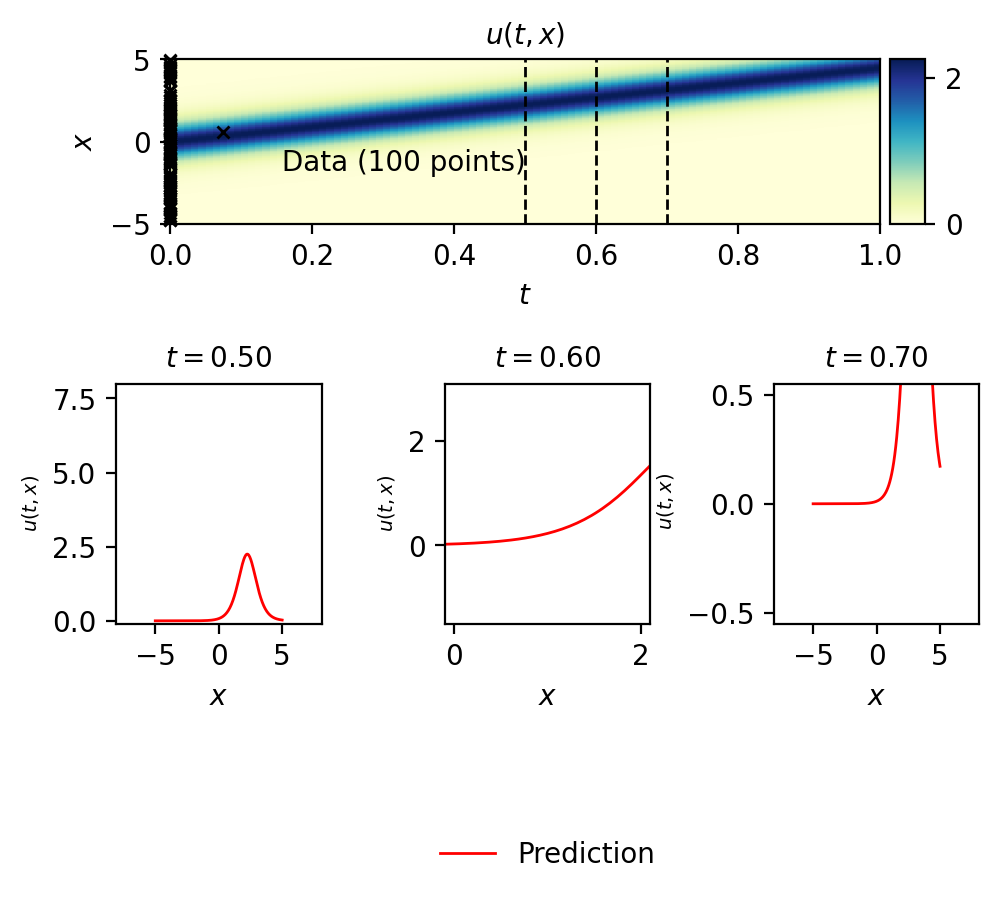

In [ ]:
if __name__ == "__main__": 

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    #V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')   #interpola os dados...

    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    #FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    

    ############################# Plotting ###############################
   
    
    X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
    X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
    X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
    X_u_train = np.vstack([X0, X_lb, X_ub])

    fig, ax = newfig(1.0, 0.9)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', #coolwarm
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = '\n \n Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
    
    
    #plot variables, Igor
    a=50
    b=a+10
    c=b+10
    ###########

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[a]*np.ones((2,1)), line, 'k--', linewidth = 1)
    ax.plot(t[b]*np.ones((2,1)), line, 'k--', linewidth = 1)
    ax.plot(t[c]*np.ones((2,1)), line, 'k--', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    leg = ax.legend(frameon=False, loc = 'best')
    #plt.setp(leg.get_texts(), color='w')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: h(t,x) slices ################## 
    '''
    #backup   
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    '''
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=0.4, bottom=0, left=0.1, right=0.9, wspace=0.6)    

    ax = plt.subplot(gs1[0, 0])
    #ax.plot(x,Exact_h[:,a], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[a,:], 'r-', linewidth = 1, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$', fontsize = 7)    
    ax.set_title('$t = %.2f$' % (t[a]), fontsize = 10)
    ax.axis('auto')
    ax.set_xlim([-8.1,8.1])
    ax.set_ylim([-0.1,8.0])
    
    ax = plt.subplot(gs1[0, 1])
    #ax.plot(x,Exact_h[:,b], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[b,:], 'r-', linewidth = 1, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$', fontsize = 7)
    ax.axis('auto')
    ax.set_xlim([-0.1,2.1])
    ax.set_ylim([-1.5,3.1])
    ax.set_title('$t = %.2f$' % (t[b]), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    #ax.plot(x,Exact_h[:,c], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[c,:], 'r-', linewidth = 1, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('\n \n $u(t,x)$', fontsize = 7)
    ax.axis('auto')#square
    ax.set_xlim([-8.1,8.1])
    ax.set_ylim([-0.55,0.55])
    ax.set_title('$t = %.2f$' % (t[c]), fontsize = 10)
    
    # savefig('./figures/NLS') 


Plot distribuição de resíduos

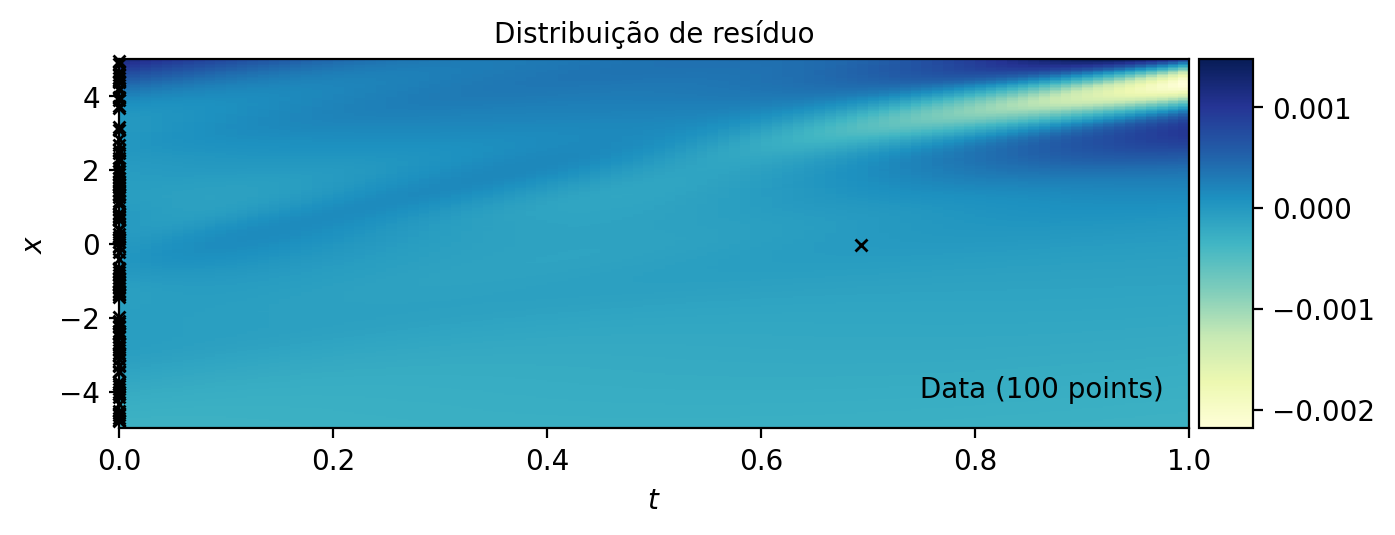

In [ ]:
    if __name__ == "__main__": 

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    U_exact= griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    #V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')   #interpola os dados...

    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    #FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    

    ############################# Plotting ###############################
   
    
    X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
    X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
    X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
    X_u_train = np.vstack([X0, X_lb, X_ub])

    fig, ax = newfig(1.5, 1.35)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(H_pred.T-U_exact.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = '\n\n\n\n\n\n \n\n\n Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
    
   # line = np.linspace(x.min(), x.max(), 2)[:,None]
   # ax.plot(t[10]*np.ones((2,1)), line, 'k--', linewidth = 1)
   # ax.plot(t[20]*np.ones((2,1)), line, 'k--', linewidth = 1)
   # ax.plot(t[30]*np.ones((2,1)), line, 'k--', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    leg = ax.legend(frameon=False, loc = 'best')
    #plt.setp(leg.get_texts(), color='w')
    ax.set_title('Distribuição de resíduo', fontsize = 10)
    '''
    ####### Row 1: h(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact_h[:,40], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[40,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[10]), fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact_h[:,50], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])
    ax.set_title('$t = %.2f$' % (t[20]), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact_h[:,60], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[60,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])    
    ax.set_title('$t = %.2f$' % (t[30]), fontsize = 10)
    
    # savefig('./figures/NLS') 
'''

Distribuição predição

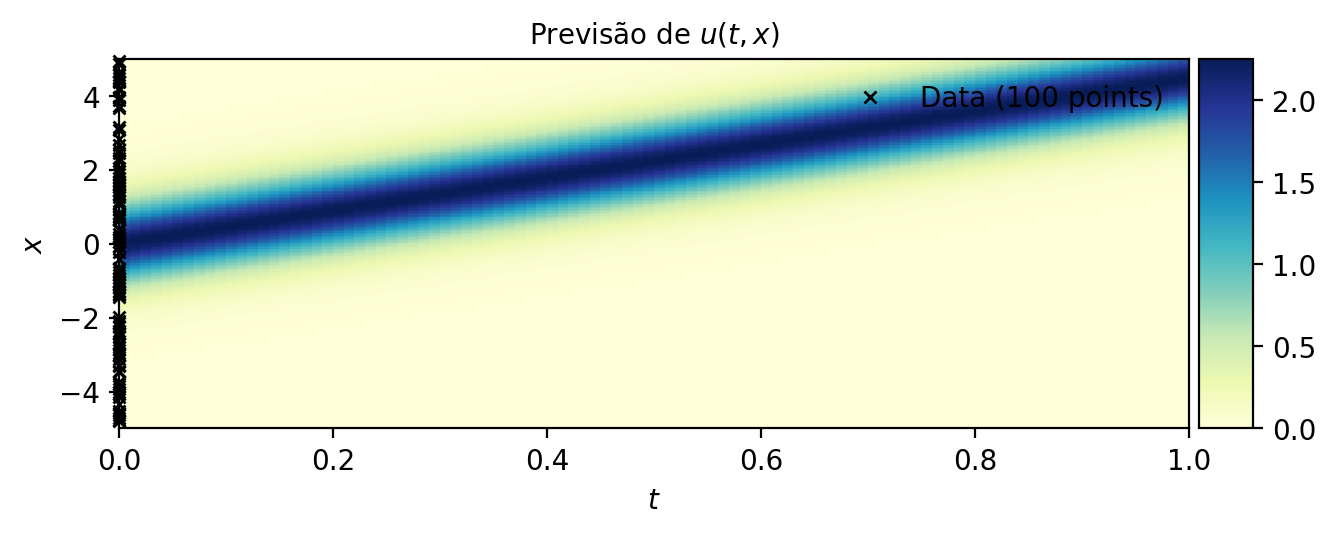

In [ ]:
if __name__ == "__main__": 

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    U_exact= griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    #V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')   #interpola os dados...

    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    #FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    

    ############################# Plotting ###############################
   
    
    X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
    X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
    X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
    X_u_train = np.vstack([X0, X_lb, X_ub])

    fig, ax = newfig(1.5,1.35)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1,2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(H_pred.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
    
   # line = np.linspace(x.min(), x.max(), 2)[:,None]
   # ax.plot(t[10]*np.ones((2,1)), line, 'k--', linewidth = 1)
   # ax.plot(t[20]*np.ones((2,1)), line, 'k--', linewidth = 1)
   # ax.plot(t[30]*np.ones((2,1)), line, 'k--', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    leg = ax.legend(frameon=False, loc = 'best')
    #plt.setp(leg.get_texts(), color='w')
    ax.set_title('Previsão de $u(t,x)$', fontsize = 10)
    '''
    ####### Row 1: h(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact_h[:,40], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[40,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[10]), fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact_h[:,50], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])
    ax.set_title('$t = %.2f$' % (t[20]), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact_h[:,60], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[60,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])    
    ax.set_title('$t = %.2f$' % (t[30]), fontsize = 10)
    
    # savefig('./figures/NLS') 
'''

Distribuição valor exato

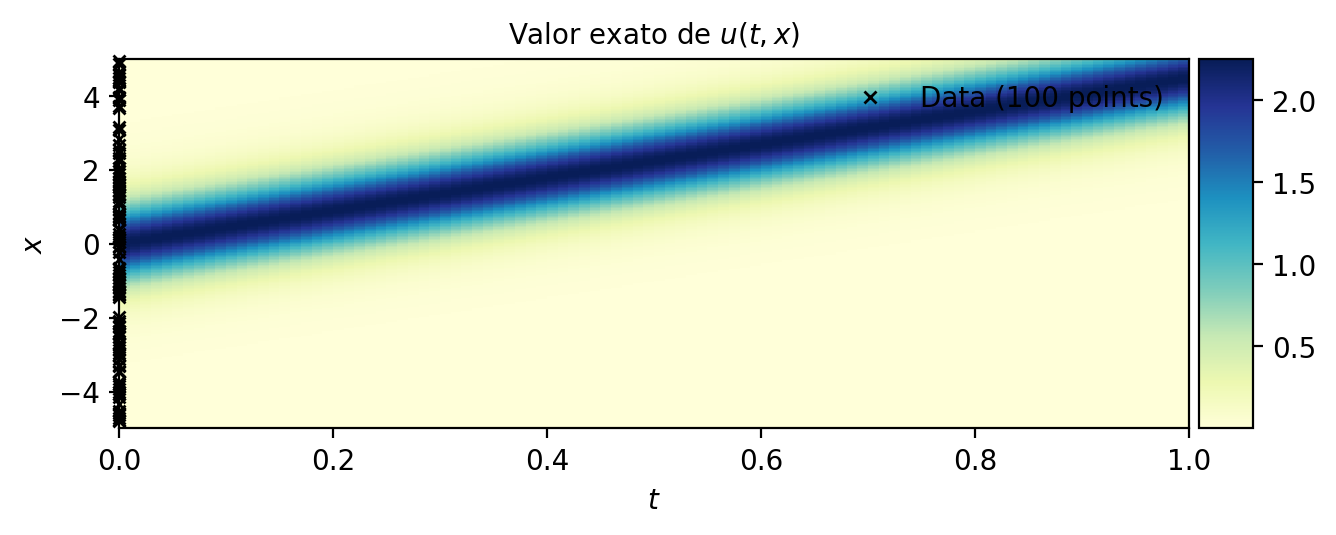

In [ ]:
if __name__ == "__main__": 

    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    U_exact= griddata(X_star, u_star.flatten(), (X, T), method='cubic')
    #V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')   #interpola os dados...

    FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    #FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')   #interpola os dados...
    

    ############################# Plotting ###############################
   
    
    X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
    X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
    X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
    X_u_train = np.vstack([X0, X_lb, X_ub])

    fig, ax = newfig(1.5, 1.35)
    ax.axis('off')
    
    ####### Row 0: h(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_exact.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (X_u_train.shape[0]), markersize = 4, clip_on = False)
    
   # line = np.linspace(x.min(), x.max(), 2)[:,None]
   # ax.plot(t[10]*np.ones((2,1)), line, 'k--', linewidth = 1)
   # ax.plot(t[20]*np.ones((2,1)), line, 'k--', linewidth = 1)
   # ax.plot(t[30]*np.ones((2,1)), line, 'k--', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    leg = ax.legend(frameon=False, loc = 'best')
    #plt.setp(leg.get_texts(), color='w')
    ax.set_title('Valor exato de $u(t,x)$', fontsize = 10)
    '''
    ####### Row 1: h(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact_h[:,40], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[40,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = %.2f$' % (t[10]), fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact_h[:,50], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])
    ax.set_title('$t = %.2f$' % (t[20]), fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact_h[:,60], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,H_pred[60,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-5.1,5.1])
    ax.set_ylim([-0.1,3.1])    
    ax.set_title('$t = %.2f$' % (t[30]), fontsize = 10)
    
    # savefig('./figures/NLS') 
'''

In [ ]:
U_exact.shape
U_pred.shape

(100, 256)